En primer lugar, debemos obtener 7 activos del dataset del sp500 que verifiquen que en su matriz de correlación, no haya ningún término que en valor absoluto sea mayor que 0.6, excepto aquellos de la diagonal principal. Con esta restricción, nos aseguraremos cierta diversificación en nuestra cartera. Usamos para estudiar la correlación los rendimientos logarítmicos de los activos, debido a que son más cercanos a estacionarios en el tiempo que los precios, y presentan propiedades más interesantes desde el punto de vista matemático y estadístico que los rendimientos simples.

In [ ]:
import pandas as pd
import yfinance as yf
import random
import numpy as np
import math
import matplotlib.pyplot as plt

numAssets = 7
tickers = pd.read_csv("sp500.csv")

'''
Función que calcula los rendimientos logarítmicos del histórico de precios
de un conjunto de activos
'''
def generateSubsetClosePrices(subset=None,startDate=None,endDate=None):
    #Si subset es nulo, querrá decir que queremos que se genere aleatoriamente un subconjunto de numAssets elementos de tickers
    if subset is None:
        subsetTickers = random.sample(tickers['Symbol'].tolist(),numAssets)
    else:
        subsetTickers = subset
    #Si la fecha de comienzo y de final son no nulas, querrá decir que queremos que se acote el histórico de precios entre dichas fechas
    if startDate is not None and endDate is not None:
        data = yf.download(subsetTickers, start=startDate, end=endDate)
    else:
        data = yf.download(subsetTickers)
    closePrices = data['Close']
    '''
    Si en el histórico de precios de cierre hay alguna columna con valor nulo para todas las fechas, querrá decir que no se tiene registro de dicha compañía,
    y por lo tanto llamaremos de forma recursiva a la función
    '''
    if closePrices.isna().all().any():
        generateSubsetClosePrices()
    returns = np.log(closePrices).diff().dropna()
    return returns,subsetTickers

'''
Función que comprueba si, dado un histórico de rendimientos para una serie de activos, su matriz de correlación correspondiente cumple las condiciones descritas
anteriormente
'''
def checkConditionCorrMatrix(returns):
    correlationMatrix = returns.corr()
    correlationMatrixArray = correlationMatrix.to_numpy()
    #Máscara que filtra por aquellos valores que no se encuentran en la diagonal principal
    mask = ~np.eye(correlationMatrixArray.shape[0], dtype=bool)
    condition = (abs(correlationMatrixArray[mask]) <= 0.6).all()
    if(condition):
        print(correlationMatrix)
    return condition    

returns,subsetTickers = generateSubsetClosePrices()
while not checkConditionCorrMatrix(returns):
    returns,subsetTickers = generateSubsetClosePrices()

#Mostramos por pantalla el nombre de las compañías cuya matriz de correlación ha satisfecho las condiciones impuestas
assetsName = tickers[tickers['Symbol'].isin(subsetTickers)]['Name'].tolist()
print(assetsName)




C:\Users\Tecnico\AppData\Local\Temp\ipykernel_13128\2684487320.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(subsetTickers)
[*********************100%***********************]  7 of 7 completed
C:\Users\Tecnico\AppData\Local\Temp\ipykernel_13128\2684487320.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(subsetTickers)
[*********************100%***********************]  7 of 7 completed

1 Failed download:
['CTLT']: YFPricesMissingError('possibly delisted; no price data found  (period=1mo) (Yahoo error = "No data found, symbol may be delisted")')
C:\Users\Tecnico\AppData\Local\Temp\ipykernel_13128\2684487320.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(subsetTickers)
[*********************100%***********************]  7 of 7 completed
C:\Users\Tecnico\AppData\Local\Temp\ipykernel_13128\2684487320.py:19: FutureWa

Ticker       ALB       ALL       BSX        FE        GL       HUM      NTAP
Ticker                                                                      
ALB     1.000000 -0.136292 -0.344071  0.122477  0.118135  0.543298 -0.173951
ALL    -0.136292  1.000000  0.208766  0.199672  0.428425 -0.047404  0.243582
BSX    -0.344071  0.208766  1.000000  0.107008  0.238023  0.065729  0.232420
FE      0.122477  0.199672  0.107008  1.000000  0.583364  0.057897  0.093977
GL      0.118135  0.428425  0.238023  0.583364  1.000000  0.072320  0.249881
HUM     0.543298 -0.047404  0.065729  0.057897  0.072320  1.000000 -0.044606
NTAP   -0.173951  0.243582  0.232420  0.093977  0.249881 -0.044606  1.000000
['Albemarle Corporation', 'Allstate', 'Boston Scientific', 'FirstEnergy', 'Globe Life', 'Humana', 'NetApp']


Una vez que hemos escogido los activos, debemos generar 100 carteras aleatorias a partir de ellos. Esto es equivalente a generar una matriz aleatoria de orden $100 \times 7$ en nuestro caso. Sobre esta matriz es necesario imponer la restricción de que cada una de sus filas debe sumar exactamente 1. El método rand de numpy utiliza la distribución uniforme sobre el intervalo $[0,1]$, por lo que no tenemos garantizada esta restricción. Va a ser necesario por tanto normalizar por filas esta matriz, aunque no utilizando la norma estándar (la euclídea), sino la de la suma (valor absoluto de la suma de las componentes de la fila a normalizar, aunque como estamos trabajando en el intervalo $[0,1]$, podemos ignorar el valor absoluto).

In [ ]:
numPortfolios = 100
weightMatrix = np.random.rand(numPortfolios,numAssets)
sums = weightMatrix.sum(axis=1, keepdims=True)
unitaryWeightMatrix = weightMatrix/sums


for i in range(unitaryWeightMatrix.shape[0]):
    text = "Cartera " + str(i + 1) + " "
    for j in range(unitaryWeightMatrix.shape[1]):
        text += subsetTickers[j] + ":" + str(unitaryWeightMatrix[i][j]) + " "
    print(text)


Cartera 1 ALL:0.12400507436881152 NTAP:0.14241968143470662 BSX:0.24918800538496802 HUM:0.27707909479438625 ALB:0.11171479865559654 FE:0.04072261519455055 GL:0.054870730166980484 
Cartera 2 ALL:0.1910452315545404 NTAP:0.09627787490589199 BSX:0.05255813142440958 HUM:0.08187608368314278 ALB:0.22349765361583004 FE:0.10908378170139509 GL:0.2456612431147903 
Cartera 3 ALL:0.13712169099273114 NTAP:0.20601912370870398 BSX:0.06625365401438771 HUM:0.2816493790021814 ALB:0.13940565080668804 FE:0.12338598025317087 GL:0.046164521222136885 
Cartera 4 ALL:0.1777622804455492 NTAP:0.16632470937561677 BSX:0.13967095268600957 HUM:0.17751464817404958 ALB:0.1130403467915021 FE:0.1316018423439148 GL:0.09408522018335803 
Cartera 5 ALL:0.16174386637680974 NTAP:0.04112592467394582 BSX:0.18465308264318267 HUM:0.003921663761232513 ALB:0.1442715473096455 FE:0.23459731759902008 GL:0.2296865976361637 
Cartera 6 ALL:0.19951529478906316 NTAP:0.10164218400219403 BSX:0.19473475822690095 HUM:0.03097455747956935 ALB:0.08

Veamos el rendimiento de las 100 carteras creadas en un escenario pasado, en este caso el período elegido ha sido el año 2024. En primer lugar, debemos ordenar el dataframe de rendimientos acorde al orden seguido para la generación de las carteras. Si denotamos por $numDias$ a la cantidad de fechas para las que tenemos datos, nuestro objetivo va a ser obtener un dataframe de orden $numDias \times 100$, a partir del dataframe original de orden $numDias \times 7$ y de la matriz de pesos normalizada de orden $100 \times 7$, por lo que debemos trasponer esta segunda matriz y multiplicarla a la derecha de la primera. Las nuevas columnas serán cada una de las 100 carteras. Finalmente, se hace uso de la libería matplotlib para poder mostrar todos los gráficos dentro de un espacio razonable.

C:\Users\Tecnico\AppData\Local\Temp\ipykernel_13128\2684487320.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(subsetTickers, start=startDate, end=endDate)
[*********************100%***********************]  7 of 7 completed


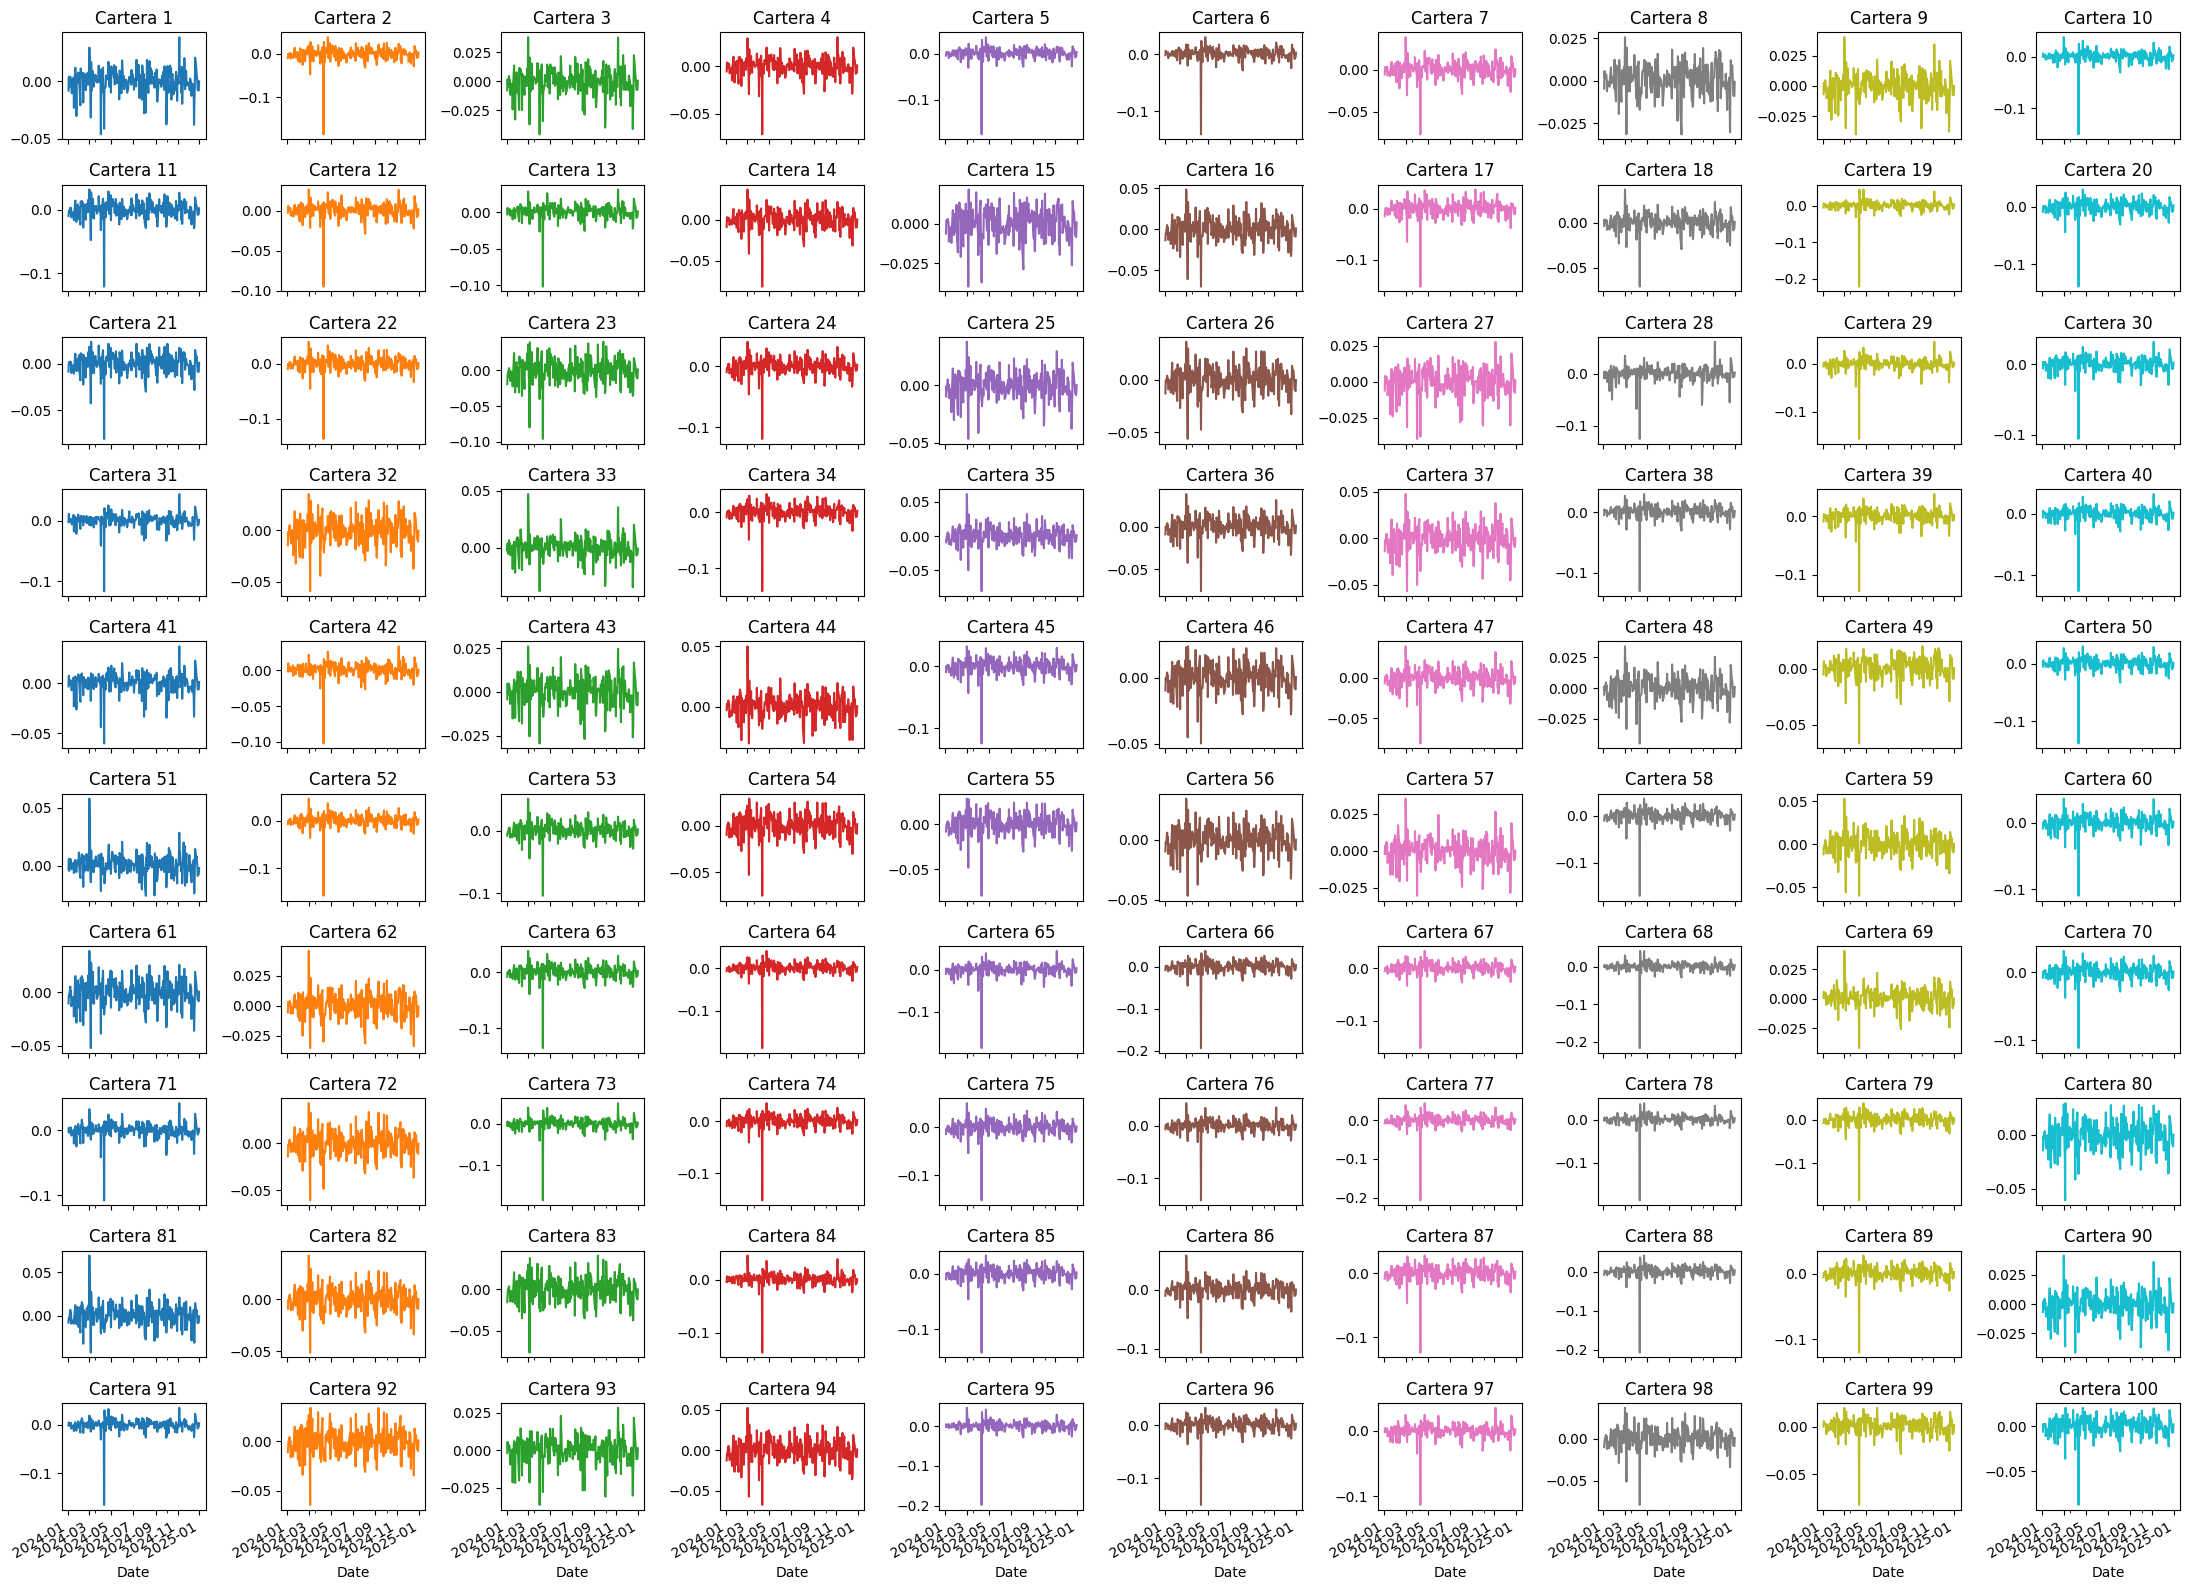

In [16]:
returns12months,_ = generateSubsetClosePrices(subsetTickers, "2024-01-01", "2025-01-01")
returns12monthsSorted = returns12months[subsetTickers]
weightedReturns = pd.DataFrame(returns12monthsSorted.values @ unitaryWeightMatrix.T, index=returns12monthsSorted.index, columns=[f"Cartera {i+1}" for i in range(unitaryWeightMatrix.shape[0])])

numSeries = weightedReturns.shape[1]
grid = math.ceil(math.sqrt(numSeries))

ax = weightedReturns.plot(subplots=True,layout=(grid,grid),figsize=(grid*2.2,grid*1.6),legend=False,sharex=True,sharey=False,title=[str(c) for c in weightedReturns.columns])

plt.tight_layout()
plt.show()

El $CVaR$ de una cartera es la media del $(1-nivelConfianza) \times 100$ % de los peores rendimientos de dicha cartera durante el período estudiado. En nuestro caso, hemos elegido $nivelConfianza = 0.95$. Se ordenan por tanto los rendimientos de 2024 de menor a mayor, por cada cartera, escogemos aquel valor que deje al 5% de las observaciones por debajo suya y calculamos la media de todos esos valores. Finalmente, nos quedamos con la cartera con menor $CVar$.

In [ ]:
#Ignoramos las filas indexadas por fecha, ya que al tener cada columna un orden en base al valor de sus rendimientos y no al tiempo, ya no es un dato relevante
weightedReturnsSorted = pd.DataFrame(np.sort(weightedReturns.values, axis=0),columns=weightedReturns.columns)
confidenceLevel = 0.95
#Queremos calcular la posición que deja al (1-confidenceLevel)% de las observaciones por debajo suya
varIndex = math.floor(weightedReturnsSorted.shape[0]*(1-confidenceLevel)) - 1
#En esta lista, guardamos la media de los rendimientos hasta varIndex por cada cartera
cVar = [np.mean(weightedReturnsSorted[col][0:varIndex]) for col in weightedReturnsSorted.columns]
#Nos quedamos con el número de posición de la cartera con menor cVar
print("La cartera con menor CVar es la " + str(np.argmin(cVar)+1))

100
La cartera con menor CVar es la 28
